## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [47]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import Image
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error


### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [13]:
df = pd.read_csv('C:/Users/KimDongyoung/Desktop/my_git/mygit/DAT/24-2/개인과제/data/TSLA.csv')

In [14]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2956 non-null   object 
 1   Open       2956 non-null   float64
 2   High       2956 non-null   float64
 3   Low        2956 non-null   float64
 4   Close      2956 non-null   float64
 5   Adj Close  2956 non-null   float64
 6   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 161.8+ KB


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [15]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [16]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [17]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...
2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_17960\454120679.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


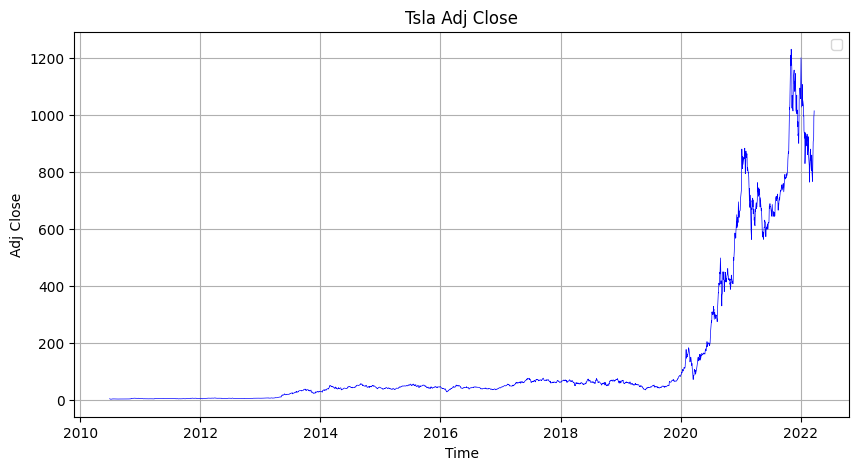

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(df['Adj Close'], linestyle='-', color='b', linewidth=0.5)
plt.title('Tsla Adj Close')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_17960\3008488232.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


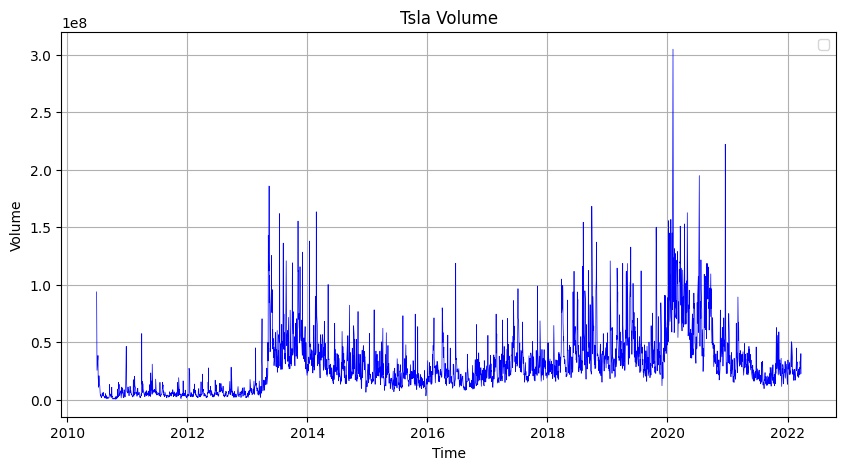

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(df['Volume'], linestyle='-', color='b', linewidth=0.5)
plt.title('Tsla Volume')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()


1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

테슬라 주식의 수성종가는 2020년을 기점으로 엄청나게 높은 성장률을 보였다. 그러다가 2차례 큰 폭락이 있긴 했으나 장기적으로 보았을 때는 우상향하는 것을 알 수 있었다.

거래량 측면에서 보았을 때는 2013년부터 2020년까지 거래량의 폭이 일정하다가 2020년을 기점으로 거래량이 매우 높아진 것을 알 수 있다. 그 이후 2021년이 지나고 난 후 부터는 다시 예전의 거래량으로 돌아왔다.

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

정상성(stationarity)은 시계열 데이터의 통계적 특성이 시간에 따라 변하지 않는 것을 의미한다. 정상성이 중요한 이유는 많은 통계적 모델과 예측 기법이 정상성을 가정하기 때문에 정상적이지 않은 데이터는 예측의 정확성을 떨어뜨릴 수 있다.

비정상성을 해결하기 위한 방법으로는 차분, 변화, 계절 조정, 추세 제거 방법이 있다.

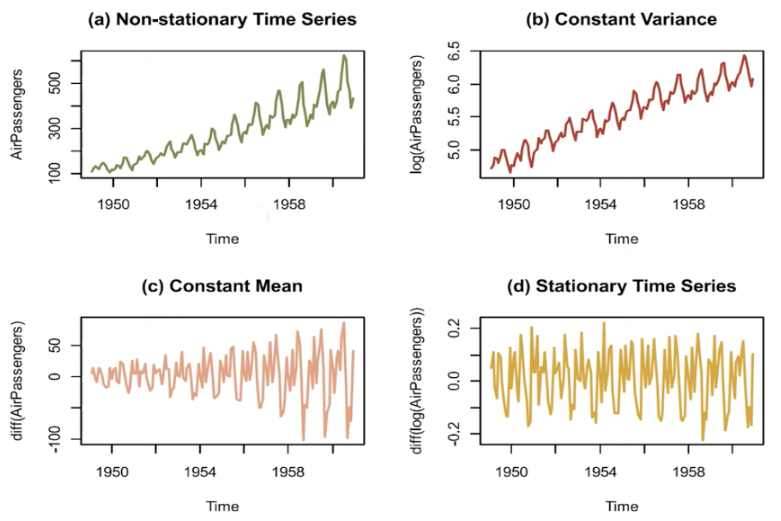

In [20]:
Image("C:/Users/KimDongyoung/Desktop/my_git/mygit/DAT/24-2/개인과제/스크린샷 2024-10-05 122856.png")

예로 위의 a와 같이 시간에 따라 변동폭이 일정하지 않고, 추세와 계절적 영향이 존재하는 비정상 시계열이 존재한다. a 그래프를 로그변환에 주면 b와 같이 변동폭이 일정해지고 차분을 하면 c와 같이 평균이 일정한 시계열로 변환된다. 

따라서 로그 변환과 차분을 함께 사용해 d와 같은 평균과 분산이 일정한 정상 시계열로 변환할 수 있다.

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [21]:
from statsmodels.tsa.stattools import adfuller

In [22]:
adj_close = df['Adj Close']

result = adfuller(adj_close)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: 1.4239415939225935
p-value: 0.9972202364261444
Critical Values:
   1%: -3.4325860929804404
   5%: -2.8625279573644873
   10%: -2.5672959172141048


2.3 ADF Test 결과를 해석하세요.

ADF statistics는 시계열 데이터가 정상성을 가지기 위해 필요한 기준값과 비교할 때 사용한다.

p-value가 0.05 크므로 귀무가설을 기각할 수 없다. 즉, 시계열 데이터가 비정상적이라는 뜻이다.

ADF Statistic(1.4239)와 각 임계값을 비교해보면 ADF Statistic이 모든 임계값보다 크기 때문에, 귀무가설을 기각할 수 없다.

2.4 

그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

ACF는 자기상관 함수로 현재 값과 과거 값 간의 상관관계를 측정한다. 특정 시간 지연(lag)에 대해 현재 값과 그 이전 값 간의 상관성을 나타낸다. 

모든 과거 값의 영향을 포함하여 현재 값과의 상관관계를 계산한다.

ACF는 일반적으로 시계열 데이터의 전체적인 패턴을 파악하는 데 유용하다.

ACF 그래프는 특정 지연에 대한 상관관계를 시각적으로 나타내며, 느리게 감소하는 경향이 있는 경우 비정상성을 나타낸다.

PACF는 부분 자기상관 함수로 특정 시간 지연에 대해 현재 값과 과거 값 간의 직접적인 상관관계를 측정한다. 즉, 다른 지연 값의 영향을 제거한 후의 상관관계를 나타낸다.

특정 지연에 대한 직접적인 상관관계만 고려하므로, 더 정확한 자기상관 정보를 제공한다.

PACF는 주로 AR(자기회귀) 모델의 차수를 결정하는 데 유용하다.

PACF 그래프에서 급격히 감소하는 경향이 있는 경우 AR 모델의 차수를 결정하는 데 도움을 준다.

ACF는 전체 과거 값의 영향을 포함한 자기상관을 측정하고, PACF는 특정 지연에 대한 직접적인 자기상관을 측정한다.

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

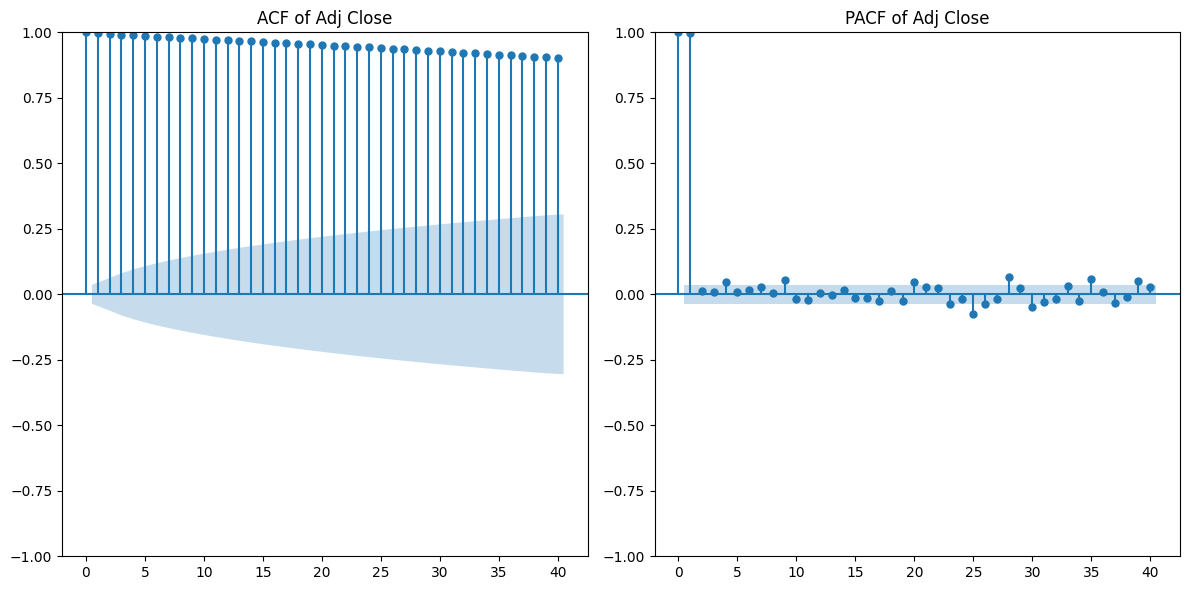

In [24]:
adj_close = df['Adj Close']

# ACF 그래프 
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(adj_close, ax=plt.gca(), lags=40)
plt.title('ACF of Adj Close')

# PACF 그래프 
plt.subplot(122)
plot_pacf(adj_close, ax=plt.gca(), lags=40)
plt.title('PACF of Adj Close')

plt.tight_layout()
plt.show()

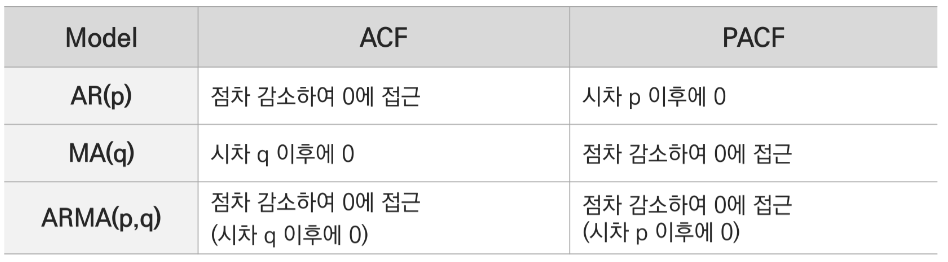

In [25]:
Image("C:/Users/KimDongyoung/Desktop/my_git/mygit/DAT/24-2/개인과제/스크린샷 2024-10-05 121956.png")

ACF 그래프와 PACF 그래프를 통해 ARIMA(p,d,q)의 p와 q를 구할 수 있다. p값은 AR(자기 회귀)의 차수, q값은 MA(이동 평균)의 차수, d값은 차분 회수를 의미한다.

AR 모형은 자기 회귀 모형으로 자기 상관성을 시계열 모형으로 구성하였으며 예측하고자 하는 특정 변수의 과거 관측값의 선형결합으로 해당 변수의 미래값을 예측하는 모형이다.

이전 자신의 관측값이 이후 자신의 관측값에 영향을 준다는 아이디어에서 기반했다.

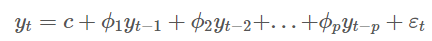

In [26]:
Image("C:/Users/KimDongyoung/Desktop/my_git/mygit/DAT/24-2/개인과제/스크린샷 2024-10-05 123540.png")

MA 모형은 이동 평균 모형으로 예측 오차를 이용하여 미래를 예측하는 모형이다.

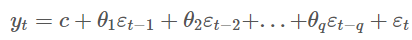

In [27]:
Image("C:/Users/KimDongyoung/Desktop/my_git/mygit/DAT/24-2/개인과제/스크린샷 2024-10-05 123727.png")

ARIMA(p,d,q) 모형은 d차 차분한 데이터에 AR(p) 모형과 MA(q) 모형을 합친 모형이다. 이때 t 시점의 예측값 y는 d차 차분을 구한 시계열, p는 자기회귀 부분의 차수, d는 차분 회수, q는 이동평균 부분의 차수이다.

즉 AR(p) 모형은 ARIMA(p,0,0) 모형과 같은 모형이고, MA(q) 모형과 ARIMA(0,0,q) 모형은 같은 모형이다.

t시점에서의 y 예측값은 d차 차분을 구한 시계열, p는 자기회귀 부분의 차수, d는 차분 회수, q는 이동평균 부분의 차수이다,

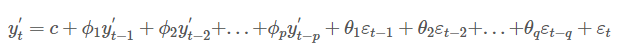

In [29]:
Image("C:/Users/KimDongyoung/Desktop/my_git/mygit/DAT/24-2/개인과제/스크린샷 2024-10-05 182953.png")

2.6 결과를 해석하세요.

ACF 그래프는 시차가 커질수록 0에 가까워진다. 정상 시계열이라면 ACF 그래프는 빠르게 0으로 수렴하며 비정상 시계열은 천천히 감소한다. 따라서 차분을 하여 정상 시계열로 변환한 뒤 ACF를 그려야 한다.

PACF 그래프는 시차가 다른 두 시계열 데이터 간의 상호 연관성을 나타낸 것으로 PACF 그래프가 시차 1에서 상당한 급등을 보여주고 이후 후속 시차에선 유의하지 않은 상관관계를 보여준다. 이는 시차 1을 사용하는 자기회귀 모형에 잘 모델링 될 수 있음을 의미한다.

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

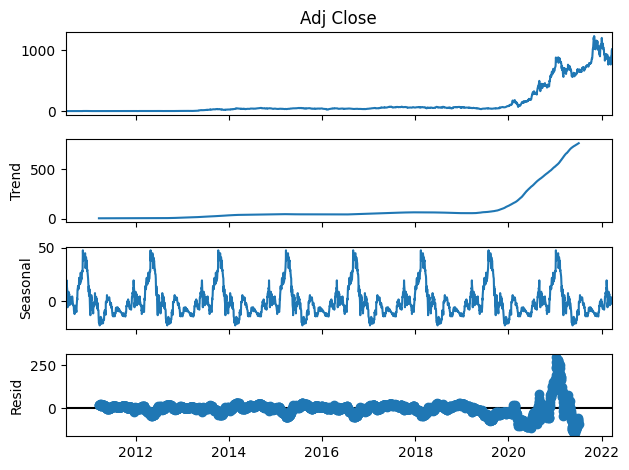

In [31]:
adj_close = df['Adj Close']

# 계절성 분해 수행 (주기 설정 필요, 예: 365일)
result = seasonal_decompose(adj_close, model='additive', period=365)

# 결과 플롯 출력
result.plot()
plt.show()

2.8 위 결과를 해석하세요.

해당 구성 요소는 관찰, 추세, 계절, 잔차로 나뉜다.

우선 관찰 그래프를 보면 2020년 전후로 상당한 변동성이 나타난다. 이는 변동성이 증가하고 시장 또는 급등을 초래하는 외부 요인과 같은 잠재적인 대규모 이벤트로 인해 주식(또는 자산)의 가치가 증가하는 것을 의미한다.

추세 그래프의 경우에는 2015년경부터 점진적인 증가를 보여주며, 2019년부터 2022년까지 급격한 상승을 보인 것을 알 수 있다.

계절적 변동은 매우 안정적이며 시간이 지남에 따라 최고점과 최저점을 반복하며 계절적 시장 상황이나 주기를 반영할 가능성이 높다. 이러한 일관된 진폭은 예측 가능하고 일정한 간격으로 반복되는 것을 의미한다.

잔차는 추세나 계절적 패턴으로 설명할 수 없는 노이즈나 불규칙적 변동을 나타낸다. 2020년까지는 잔차가 비교적 안정적이다가 이후 패턴을 방해하고 가격을 예측할 수 없도록 하는 중요한 이벤트가 나타난 것을 알 수 있다.





2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

차분은 수학에서 두 개의 수나 함수의 차이를 계산하는 개념입니다. 주로 미분이나 수치적 분석에서 사용되며, 연속적인 데이터나 함수의 변화율을 이해하는 데 도움이 된다.

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [32]:
adj_close = df['Adj Close']

adj_close_diff = adj_close.diff().dropna()

result = adfuller(adj_close_diff)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -9.844955339484903
p-value: 4.6460882120911366e-17
Critical Values:
   1%: -3.432586857867417
   5%: -2.862528295182304
   10%: -2.567296097065506


ADF Statistic (-9.8449)은 모든 Critical Value보다 작고 p-value (4.6461e-17)는 0.05보다 작기 때문에 귀무가설을 기각할 수 있으며, 이 데이터는 정상성을 가진다고 할 수 있다.

2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

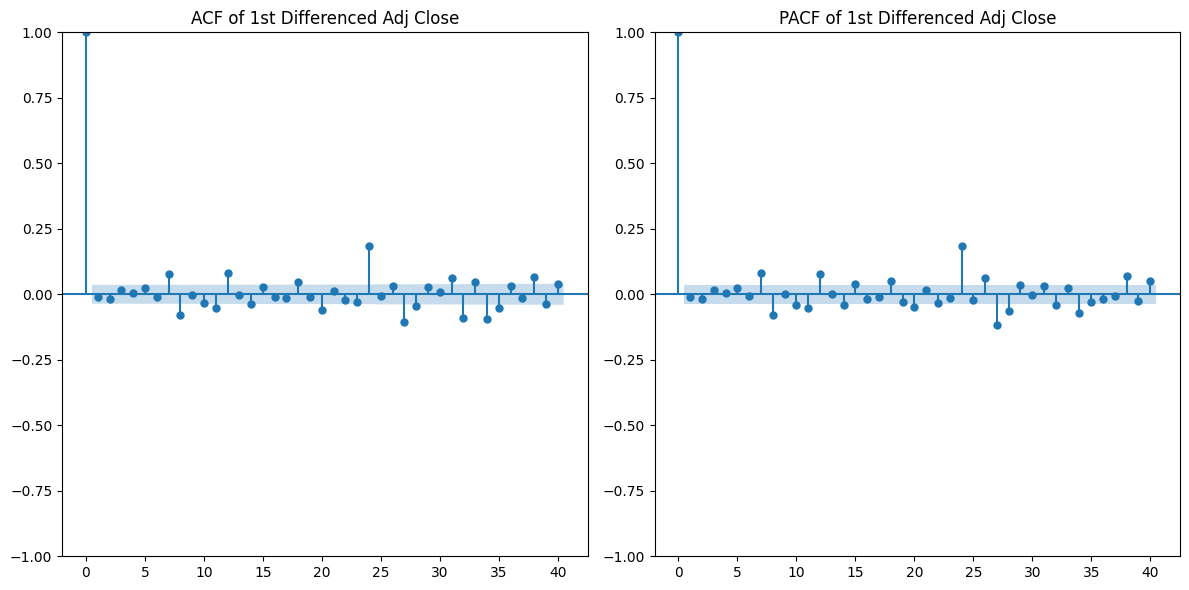

In [33]:
# ACF 플롯 그리기
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(adj_close_diff, ax=plt.gca(), lags=40)
plt.title('ACF of 1st Differenced Adj Close')

# PACF 플롯 그리기
plt.subplot(122)
plot_pacf(adj_close_diff, ax=plt.gca(), lags=40)
plt.title('PACF of 1st Differenced Adj Close')

plt.tight_layout()
plt.show()

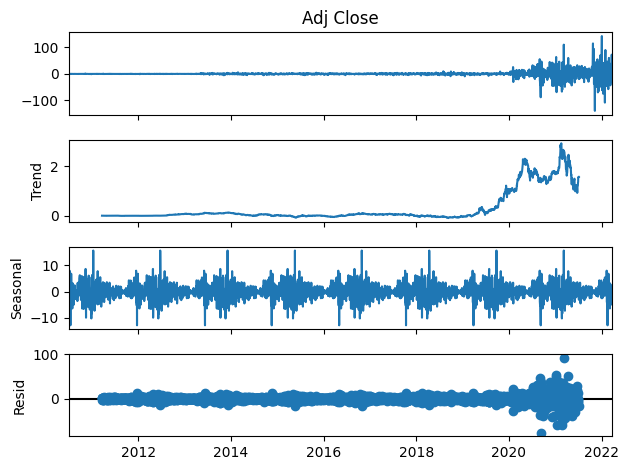

In [34]:
result = seasonal_decompose(adj_close_diff, model='additive', period=365)

# 계절성 분해 결과 플롯 출력
result.plot()
plt.show()

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [36]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [43]:
df['Adj Close']

Date
2010-06-29       4.778000
2010-06-30       4.766000
2010-07-01       4.392000
2010-07-02       3.840000
2010-07-06       3.222000
                 ...     
2022-03-18     905.390015
2022-03-21     921.159973
2022-03-22     993.979980
2022-03-23     999.109985
2022-03-24    1013.919983
Name: Adj Close, Length: 2956, dtype: float64

In [44]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Adj Close'].values.reshape(-1, 1))

def create_dataset(data, time_step=1):
  X, Y = [], []
  for i in range(len(data) - time_step - 1):
    a = data[i:(i + time_step), 0]
    X.append(a)
    Y.append(data[i + time_step, 0])
  return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(scaled_data, time_step)

# 데이터셋을 훈련 및 테스트 세트로 분할
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# LSTM 입력 형식에 맞게 데이터 재구성
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [48]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련
model.fit(X_train, Y_train, batch_size=1, epochs=1)

# 예측 수행
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 데이터 역정규화
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# MSE 계산
train_mse = mean_squared_error(scaler.inverse_transform(Y_train.reshape(-1, 1)), train_predict)
test_mse = mean_squared_error(scaler.inverse_transform(Y_test.reshape(-1, 1)), test_predict)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')


c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2284/2284 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 4.0368e-05
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Train MSE: 13.077331771457551
Test MSE: 20960.46934368233


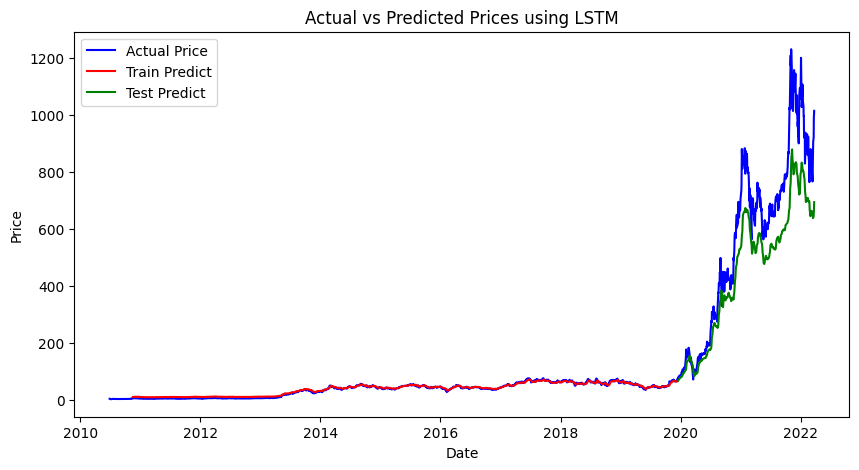

In [49]:
# 예측 결과 시각화
plt.figure(figsize=(10, 5))

# 실제 데이터 플롯
plt.plot(df['Adj Close'].index, df['Adj Close'].values, label='Actual Price', color='blue')

# 훈련 데이터 예측 플롯
train_predict_len = len(train_predict)
plt.plot(df['Adj Close'].index[time_step:time_step + train_predict_len], train_predict.flatten(), label='Train Predict', color='red')

# 테스트 데이터 예측 플롯
test_predict_len = len(test_predict)
plt.plot(df['Adj Close'].index[time_step + train_predict_len + 1:time_step + train_predict_len + 1 + test_predict_len], test_predict.flatten(), label='Test Predict', color='green')

# 플롯 설정
plt.title('Actual vs Predicted Prices using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


예측값을 보았을 때 실제값과 추세와 변동 방향성이 일치하는 것을 알 수 있었다.

ARIMA에서는 성능이 왠지는 모르겠으나 잘 안 나와서 이정도만 하고 넘어가겠습니다. 밑에서 진행할 Prophet 모형의 경우 예측이 제대로 진행되어 추세를 예측하고자 단기적 예측이라 할 수 있는 50일이 아닌 향후 200일을 예측하였습니다.